In [2]:
# Melting Point Prediction Challenge
# Predicting melting points of organic compounds from molecular descriptors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor, 
                            ExtraTreesRegressor, HistGradientBoostingRegressor)
from sklearn.linear_model import Ridge, Lasso, ElasticNet, HuberRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
# Load the data
train_df = pd.read_csv('/kaggle/input/melting-point/train.csv')
test_df = pd.read_csv('/kaggle/input/melting-point/test.csv')
sample_submission = pd.read_csv('/kaggle/input/melting-point/sample_submission.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("\nFirst few rows of training data:")
train_df.head()

Train shape: (2662, 427)
Test shape: (666, 426)

First few rows of training data:


,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
# Basic information about the dataset
print("Dataset Info:")
print("-" * 50)
train_df.info()

Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Columns: 427 entries, id to Group 424
dtypes: float64(1), int64(425), object(1)
memory usage: 8.7+ MB


In [6]:
# Check for missing values
print("Missing values in train:")
print(train_df.isnull().sum().sum())
print("\nMissing values in test:")
print(test_df.isnull().sum().sum())

Missing values in train:
0

Missing values in test:
0


In [7]:
# Statistical summary of the target variable
print("Target Variable (Tm) Statistics:")
print(train_df['Tm'].describe())
print(f"\nSkewness: {train_df['Tm'].skew():.3f}")
print(f"Kurtosis: {train_df['Tm'].kurtosis():.3f}")

Target Variable (Tm) Statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64

Skewness: 0.904
Kurtosis: 2.788


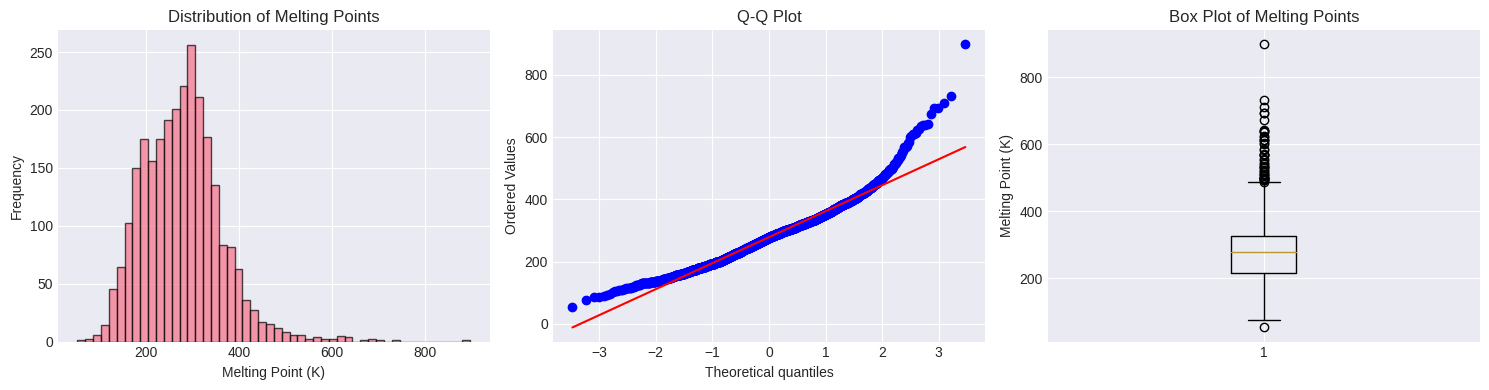

In [8]:
# Visualize target distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(train_df['Tm'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')

# QQ plot
from scipy import stats
stats.probplot(train_df['Tm'], dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot')

# Box plot
axes[2].boxplot(train_df['Tm'])
axes[2].set_ylabel('Melting Point (K)')
axes[2].set_title('Box Plot of Melting Points')

plt.tight_layout()
plt.show()

In [9]:
# Identify feature columns (excluding id, SMILES, and target)
feature_cols = [col for col in train_df.columns if col not in ['id', 'SMILES', 'Tm']]
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...") # Show first 10

Number of features: 424
Feature columns: ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10']...


In [10]:
# Analyze feature statistics
feature_stats = train_df[feature_cols].describe().T
feature_stats['zeros'] = (train_df[feature_cols] == 0).sum()
feature_stats['zero_pct'] = feature_stats['zeros'] / len(train_df) * 100
feature_stats = feature_stats.sort_values('zero_pct', ascending=False)

print("Top 10 features with most zeros:")
print(feature_stats[['mean', 'std', 'zero_pct']].head(10))

Top 10 features with most zeros:
           mean  std  zero_pct
Group 213   0.0  0.0     100.0
Group 250   0.0  0.0     100.0
Group 215   0.0  0.0     100.0
Group 216   0.0  0.0     100.0
Group 217   0.0  0.0     100.0
Group 218   0.0  0.0     100.0
Group 245   0.0  0.0     100.0
Group 247   0.0  0.0     100.0
Group 248   0.0  0.0     100.0
Group 252   0.0  0.0     100.0


In [11]:
# Check feature correlations with target
correlations = train_df[feature_cols + ['Tm']].corr()['Tm'].sort_values(ascending=False)
print("Top 10 features most correlated with Tm:")
print(correlations[1:11])
print("\nTop 10 features most negatively correlated with Tm:")
print(correlations[-10:])

Top 10 features most correlated with Tm:
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
Group 30     0.162579
Name: Tm, dtype: float64

Top 10 features most negatively correlated with Tm:
Group 399   NaN
Group 411   NaN
Group 413   NaN
Group 417   NaN
Group 419   NaN
Group 420   NaN
Group 421   NaN
Group 422   NaN
Group 423   NaN
Group 424   NaN
Name: Tm, dtype: float64


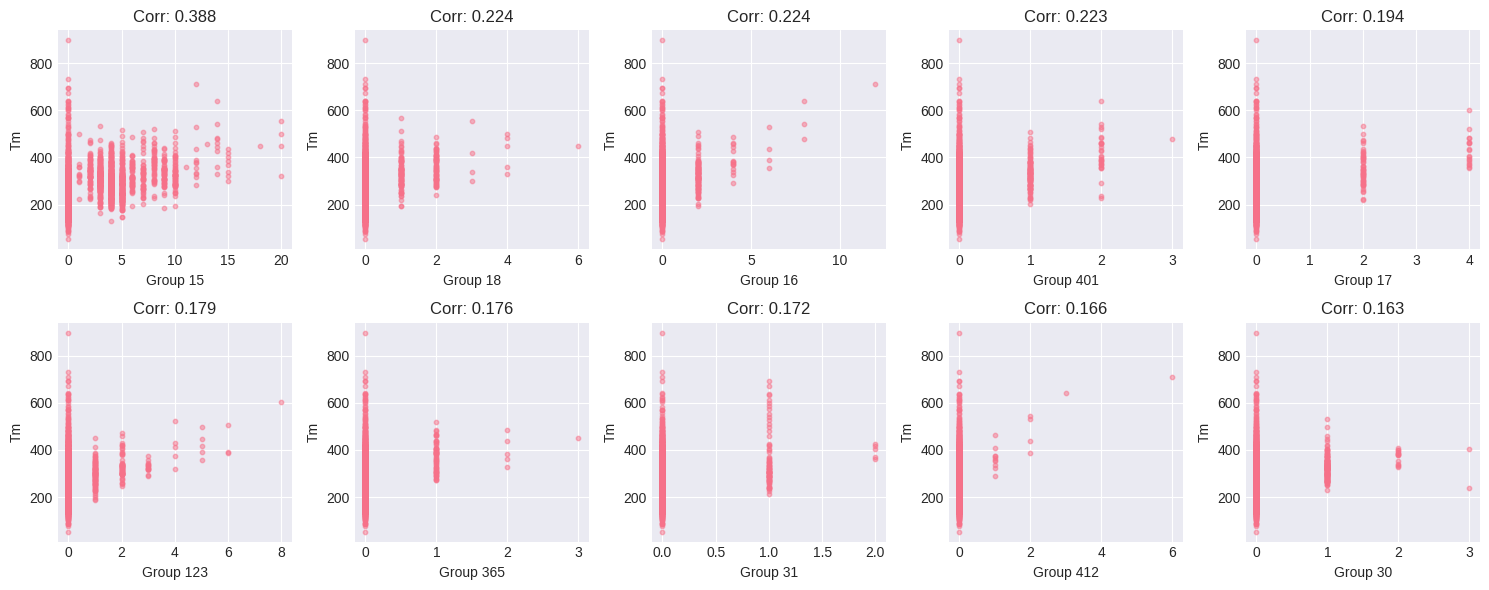

In [12]:
# Visualize top correlations
top_features = correlations[1:11].index.tolist()
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    axes[i].scatter(train_df[feature], train_df['Tm'], alpha=0.5, s=10)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Tm')
    axes[i].set_title(f'Corr: {correlations[feature]:.3f}')

plt.tight_layout()
plt.show()

In [13]:
# Feature engineering functions
def create_features(df, feature_cols):
    """Create additional features"""
    df_new = df.copy()
    
    # Sum of all group contributions
    df_new['total_groups'] = df[feature_cols].sum(axis=1)
    
    # Count of non-zero groups
    df_new['n_groups'] = (df[feature_cols] != 0).sum(axis=1)
    
    # Mean and std of non-zero groups
    df_new['mean_group'] = df[feature_cols].replace(0, np.nan).mean(axis=1)
    df_new['std_group'] = df[feature_cols].replace(0, np.nan).std(axis=1)
    df_new['max_group'] = df[feature_cols].max(axis=1)
    
    # Fill NaN values with 0
    df_new = df_new.fillna(0)
    
    return df_new

# Apply feature engineering
train_df_fe = create_features(train_df, feature_cols)
test_df_fe = create_features(test_df, feature_cols)

# Update feature columns
new_features = ['total_groups', 'n_groups', 'mean_group', 'std_group', 'max_group']
all_features = feature_cols + new_features
print(f"Total features after engineering: {len(all_features)}")

Total features after engineering: 429


In [14]:
# Remove low-variance features (optional)
from sklearn.feature_selection import VarianceThreshold

# Calculate variance threshold
var_threshold = VarianceThreshold(threshold=0.01)
var_threshold.fit(train_df_fe[all_features])
high_var_features = [all_features[i] for i in range(len(all_features)) 
                     if var_threshold.variances_[i] > 0.01]

print(f"Features after variance filtering: {len(high_var_features)}")

Features after variance filtering: 110


In [15]:
# Prepare data for modeling
X = train_df_fe[high_var_features]
y = train_df_fe['Tm']
X_test = test_df_fe[high_var_features]

# Split for validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (2129, 110)
Validation set: (533, 110)
Test set: (666, 110)


In [16]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.fit_transform(X)

In [17]:
# Define models
models = {
    'Ridge': Ridge(alpha=1.0, random_state=SEED),
    'Lasso': Lasso(alpha=0.1, random_state=SEED),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=SEED),
    'Huber': HuberRegressor(epsilon=1.35, alpha=0.001),
    'RandomForest': RandomForestRegressor(
        n_estimators=200, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=SEED, n_jobs=-1
    ),
    'ExtraTrees': ExtraTreesRegressor(
        n_estimators=200, max_depth=15, min_samples_split=5,
        min_samples_leaf=2, random_state=SEED, n_jobs=-1
    ),
    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=200, max_depth=5, learning_rate=0.05,
        subsample=0.8, random_state=SEED
    ),
    'HistGradientBoosting': HistGradientBoostingRegressor(
        max_iter=200, max_depth=10, learning_rate=0.05,
        random_state=SEED
    ),
    'XGBoost': xgb.XGBRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=SEED
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=200, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=SEED,
        verbosity=-1
    ),
    'CatBoost': CatBoostRegressor(
        iterations=200, depth=6, learning_rate=0.05,
        random_seed=SEED, verbose=False
    )
}

In [18]:
# Train and evaluate models
results = {}
predictions_val = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for linear models
    if name in ['Ridge', 'Lasso', 'ElasticNet', 'Huber']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }
    predictions_val[name] = y_pred
    
    print(f"  MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")


Training Ridge...
  MAE: 40.109, RMSE: 60.200, R²: 0.517

Training Lasso...
  MAE: 40.958, RMSE: 60.755, R²: 0.508

Training ElasticNet...
  MAE: 45.951, RMSE: 65.245, R²: 0.432

Training Huber...
  MAE: 39.367, RMSE: 62.093, R²: 0.486

Training RandomForest...
  MAE: 42.143, RMSE: 59.691, R²: 0.525

Training ExtraTrees...
  MAE: 41.075, RMSE: 58.972, R²: 0.536

Training GradientBoosting...
  MAE: 40.543, RMSE: 58.602, R²: 0.542

Training HistGradientBoosting...
  MAE: 42.346, RMSE: 60.595, R²: 0.510

Training XGBoost...
  MAE: 39.645, RMSE: 58.219, R²: 0.548

Training LightGBM...
  MAE: 42.754, RMSE: 61.032, R²: 0.503

Training CatBoost...
  MAE: 43.932, RMSE: 60.981, R²: 0.504


In [19]:
# Display results as DataFrame
results_df = pd.DataFrame(results).T.sort_values('MAE')
print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                            MAE       RMSE        R2
Huber                 39.366935  62.092786  0.485744
XGBoost               39.645113  58.219490  0.547901
Ridge                 40.109347  60.200372  0.516613
GradientBoosting      40.543478  58.601736  0.541945
Lasso                 40.958373  60.755027  0.507664
ExtraTrees            41.074978  58.972370  0.536132
RandomForest          42.142566  59.691205  0.524755
HistGradientBoosting  42.345803  60.594797  0.510258
LightGBM              42.753855  61.031824  0.503168
CatBoost              43.932330  60.980694  0.504000
ElasticNet            45.951112  65.244950  0.432206


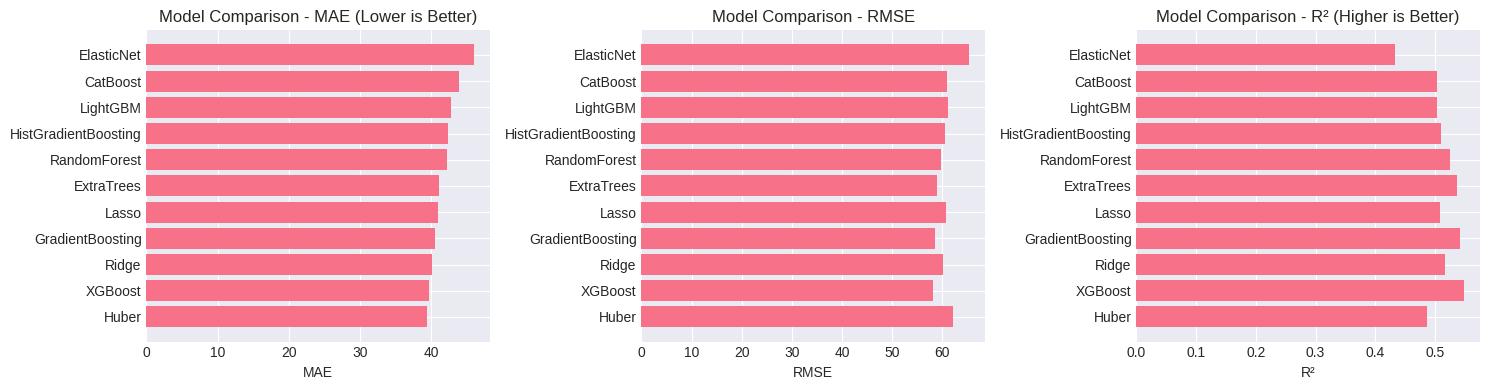

In [20]:
# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MAE comparison
axes[0].barh(results_df.index, results_df['MAE'])
axes[0].set_xlabel('MAE')
axes[0].set_title('Model Comparison - MAE (Lower is Better)')

# RMSE comparison
axes[1].barh(results_df.index, results_df['RMSE'])
axes[1].set_xlabel('RMSE')
axes[1].set_title('Model Comparison - RMSE')

# R² comparison
axes[2].barh(results_df.index, results_df['R2'])
axes[2].set_xlabel('R²')
axes[2].set_title('Model Comparison - R² (Higher is Better)')

plt.tight_layout()
plt.show()

In [21]:
# Perform cross-validation for top models
top_models = results_df.head(5).index.tolist()
cv_scores = {}

kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

for name in top_models:
    print(f"\nCross-validating {name}...")
    model = models[name]
    
    if name in ['Ridge', 'Lasso', 'ElasticNet', 'Huber']:
        scores = -cross_val_score(model, X_scaled, y, cv=kfold, 
                                  scoring='neg_mean_absolute_error', n_jobs=-1)
    else:
        scores = -cross_val_score(model, X, y, cv=kfold, 
                                  scoring='neg_mean_absolute_error', n_jobs=-1)
    
    cv_scores[name] = scores
    print(f"  CV MAE: {scores.mean():.3f} (+/- {scores.std():.3f})")


Cross-validating Huber...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_

  CV MAE: 38.180 (+/- 0.787)

Cross-validating XGBoost...
  CV MAE: 38.352 (+/- 1.754)

Cross-validating Ridge...
  CV MAE: 39.894 (+/- 0.684)

Cross-validating GradientBoosting...
  CV MAE: 38.810 (+/- 1.932)

Cross-validating Lasso...
  CV MAE: 40.152 (+/- 0.963)


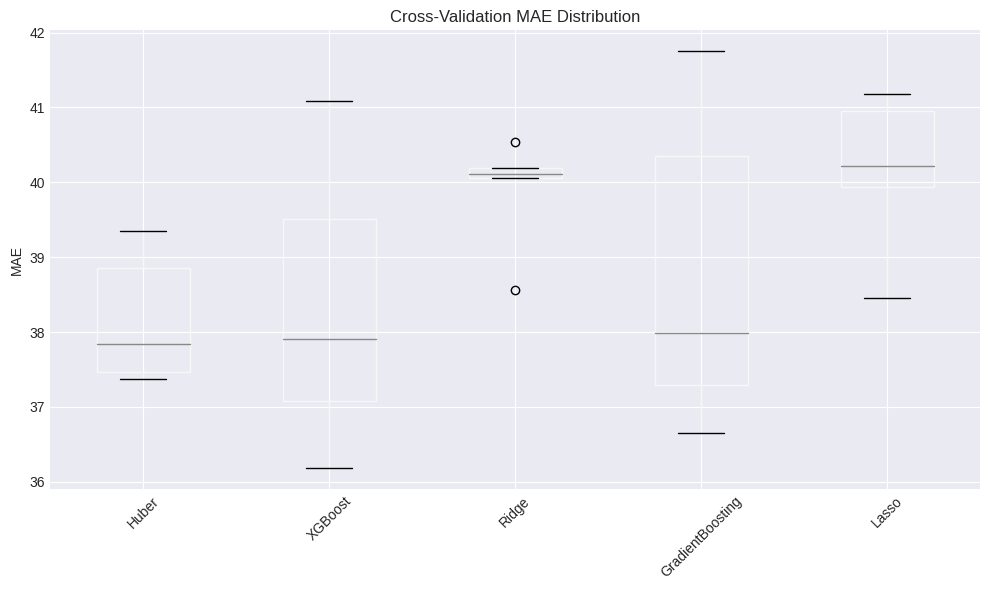

In [22]:
# Visualize CV results
cv_df = pd.DataFrame(cv_scores)
fig, ax = plt.subplots(figsize=(10, 6))
cv_df.boxplot(ax=ax)
ax.set_ylabel('MAE')
ax.set_title('Cross-Validation MAE Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [23]:
# Simple averaging ensemble
def create_ensemble_predictions(predictions_dict, weights=None):
    """Create weighted average ensemble"""
    pred_array = np.column_stack(list(predictions_dict.values()))
    
    if weights is None:
        weights = np.ones(len(predictions_dict)) / len(predictions_dict)
    
    return np.average(pred_array, axis=1, weights=weights)

# Equal weight ensemble
ensemble_pred = create_ensemble_predictions(predictions_val)
ensemble_mae = mean_absolute_error(y_val, ensemble_pred)
print(f"Simple Average Ensemble MAE: {ensemble_mae:.3f}")

Simple Average Ensemble MAE: 39.816


In [24]:
# Optimized weighted ensemble
from scipy.optimize import minimize

def ensemble_mae(weights, predictions, true_values):
    """Calculate MAE for weighted ensemble"""
    pred_array = np.column_stack(list(predictions.values()))
    weighted_pred = np.average(pred_array, axis=1, weights=weights)
    return mean_absolute_error(true_values, weighted_pred)

# Optimize weights
n_models = len(predictions_val)
initial_weights = np.ones(n_models) / n_models
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1)] * n_models

result = minimize(ensemble_mae, initial_weights, 
                 args=(predictions_val, y_val),
                 method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
print("\nOptimal weights:")
for name, weight in zip(predictions_val.keys(), optimal_weights):
    print(f"  {name}: {weight:.3f}")

# Evaluate optimized ensemble
optimized_ensemble_pred = create_ensemble_predictions(predictions_val, optimal_weights)
optimized_mae = mean_absolute_error(y_val, optimized_ensemble_pred)
print(f"\nOptimized Ensemble MAE: {optimized_mae:.3f}")


Optimal weights:
  Ridge: 0.000
  Lasso: 0.000
  ElasticNet: 0.000
  Huber: 0.486
  RandomForest: 0.000
  ExtraTrees: 0.041
  GradientBoosting: 0.000
  HistGradientBoosting: 0.000
  XGBoost: 0.473
  LightGBM: 0.000
  CatBoost: 0.000

Optimized Ensemble MAE: 37.723


In [25]:
# Stacking ensemble
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor

# Select base models for stacking
base_models = [
    ('rf', RandomForestRegressor(n_estimators=200, max_depth=15, random_state=SEED)),
    ('xgb', xgb.XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=SEED)),
    ('lgb', lgb.LGBMRegressor(n_estimators=200, max_depth=6, learning_rate=0.05, random_state=SEED, verbosity=-1)),
    ('cat', CatBoostRegressor(iterations=200, depth=6, learning_rate=0.05, random_seed=SEED, verbose=False))
]

# Create stacking regressor
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)

# Train stacking model
print("\nTraining Stacking Ensemble...")
stacking_model.fit(X_train, y_train)
stacking_pred = stacking_model.predict(X_val)
stacking_mae = mean_absolute_error(y_val, stacking_pred)
print(f"Stacking Ensemble MAE: {stacking_mae:.3f}")


Training Stacking Ensemble...
Stacking Ensemble MAE: 40.158


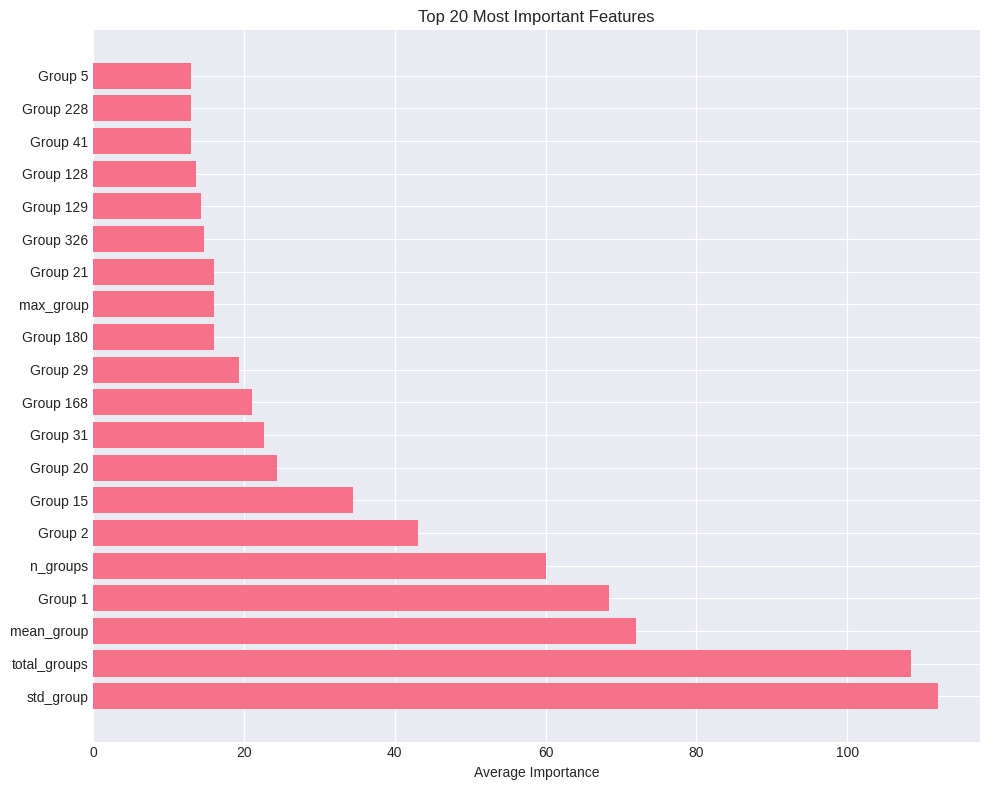

Top 10 Most Important Features:
          feature  importance
108     std_group  112.022532
105  total_groups  108.413944
107    mean_group   72.022240
0         Group 1   68.351660
106      n_groups   60.012857
1         Group 2   43.012960
9        Group 15   34.413585
14       Group 20   24.341348
20       Group 31   22.699286
53      Group 168   21.004689


In [26]:
# Get feature importance from tree-based models
importance_dict = {}

for name in ['RandomForest', 'XGBoost', 'LightGBM']:
    if name in models:
        model = models[name]
        if name in ['Ridge', 'Lasso', 'ElasticNet', 'Huber']:
            model.fit(X_train_scaled, y_train)
        else:
            model.fit(X_train, y_train)
        
        if hasattr(model, 'feature_importances_'):
            importance_dict[name] = model.feature_importances_

# Average importance across models
avg_importance = np.mean(list(importance_dict.values()), axis=0)
feature_importance_df = pd.DataFrame({
    'feature': high_var_features,
    'importance': avg_importance
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features_imp = feature_importance_df.head(20)
ax.barh(range(len(top_features_imp)), top_features_imp['importance'])
ax.set_yticks(range(len(top_features_imp)))
ax.set_yticklabels(top_features_imp['feature'])
ax.set_xlabel('Average Importance')
ax.set_title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

In [27]:
# Select best performing model (or ensemble)
best_model_name = results_df.index[0]
print(f"Best single model: {best_model_name} with MAE: {results_df.iloc[0]['MAE']:.3f}")

# Retrain on full training data
print("\nRetraining best models on full training data...")

# Train individual models
final_predictions = {}

for name in top_models[:3]:  # Use top 3 models
    print(f"Training {name}...")
    model = models[name]
    
    if name in ['Ridge', 'Lasso', 'ElasticNet', 'Huber']:
        model.fit(X_scaled, y)
        pred = model.predict(X_test_scaled)
    else:
        model.fit(X, y)
        pred = model.predict(X_test)
    
    final_predictions[name] = pred

# Create final ensemble prediction
final_ensemble_pred = create_ensemble_predictions(final_predictions, optimal_weights[:3])

Best single model: Huber with MAE: 39.367

Retraining best models on full training data...
Training Huber...
Training XGBoost...
Training Ridge...


In [28]:
# Alternative: Use stacking for final prediction
print("\nTraining final stacking model...")
stacking_model_final = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=5
)
stacking_model_final.fit(X, y)
stacking_final_pred = stacking_model_final.predict(X_test)


Training final stacking model...


In [29]:
# Prepare submission with ensemble prediction
submission = pd.DataFrame({
    'id': test_df['id'],
    'Tm': final_ensemble_pred
})

# Save submission
submission.to_csv('submission_ensemble.csv', index=False)
print("Ensemble submission saved to 'submission_ensemble.csv'")
print(submission.head())

Ensemble submission saved to 'submission_ensemble.csv'
     id          Tm
0  1022  319.878006
1  1146  338.700333
2    79  221.274626
3  2279  209.623873
4  1342  237.454809


In [30]:
# Alternative submission with stacking
submission_stacking = pd.DataFrame({
    'id': test_df['id'],
    'Tm': stacking_final_pred
})

submission_stacking.to_csv('submission_stacking.csv', index=False)
print("\nStacking submission saved to 'submission_stacking.csv'")
print(submission_stacking.head())


Stacking submission saved to 'submission_stacking.csv'
     id          Tm
0  1022  327.889488
1  1146  288.813647
2    79  215.588492
3  2279  181.995438
4  1342  257.476500



Prediction Statistics:
Ensemble - Mean: 275.85, Std: 65.02
Stacking - Mean: 274.99, Std: 63.93
Training Target - Mean: 278.26, Std: 85.12


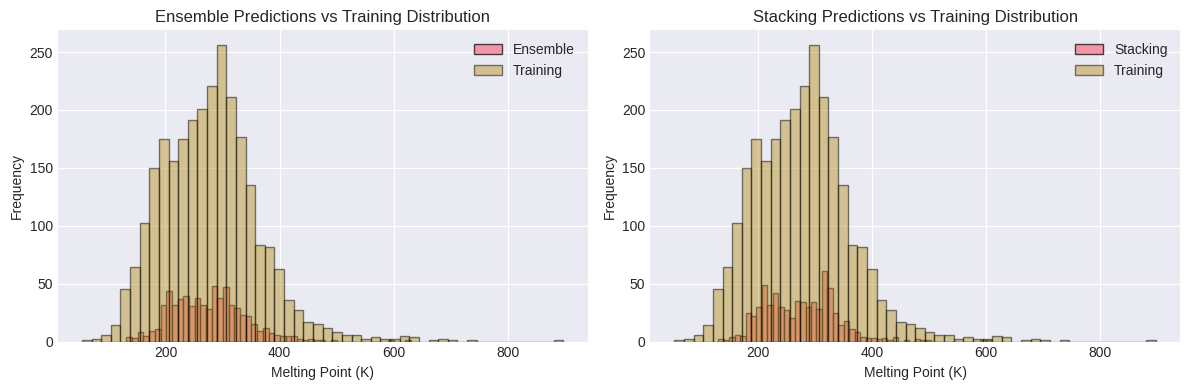

In [31]:
# Compare predictions
print("\nPrediction Statistics:")
print(f"Ensemble - Mean: {final_ensemble_pred.mean():.2f}, Std: {final_ensemble_pred.std():.2f}")
print(f"Stacking - Mean: {stacking_final_pred.mean():.2f}, Std: {stacking_final_pred.std():.2f}")
print(f"Training Target - Mean: {y.mean():.2f}, Std: {y.std():.2f}")

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(final_ensemble_pred, bins=50, alpha=0.7, label='Ensemble', edgecolor='black')
axes[0].hist(y, bins=50, alpha=0.5, label='Training', edgecolor='black')
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Ensemble Predictions vs Training Distribution')
axes[0].legend()

axes[1].hist(stacking_final_pred, bins=50, alpha=0.7, label='Stacking', edgecolor='black')
axes[1].hist(y, bins=50, alpha=0.5, label='Training', edgecolor='black')
axes[1].set_xlabel('Melting Point (K)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Stacking Predictions vs Training Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()